# Import dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

100%|██████████| 60.3M/60.3M [00:00<00:00, 133MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


# Import librairies

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib
import os
import numpy as np
import cv2
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Data exploration

In [3]:
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

In [4]:
train_dir = '/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/train'
test_dir = '/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1/test'
print(count_files_in_subdirs(train_dir,'train_dir'))
print(count_files_in_subdirs(test_dir,'test_dir'))

            sad  fear  happy  surprise  angry  neutral  disgust
train_dir  4830  4097   7215      3171   3995     4965      436
           sad  fear  happy  surprise  angry  neutral  disgust
test_dir  1247  1024   1774       831    958     1233      111


In [5]:
emotions = [f.name for f in os.scandir(train_dir) if f.is_dir()]
print(emotions)

['sad', 'fear', 'happy', 'surprise', 'angry', 'neutral', 'disgust']


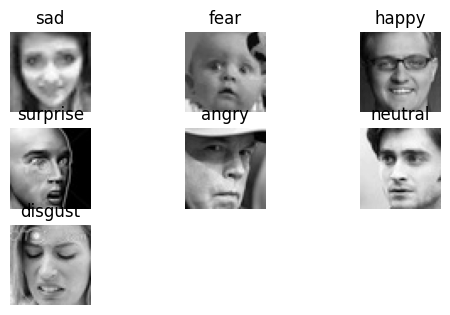

In [6]:
n=0
for emotion in emotions:
  n+=1
  folder_path=os.path.join(train_dir,emotion)
  img_path = os.path.join(folder_path, os.listdir(folder_path)[1])
  img=plt.imread(img_path)
  plt.subplot(4,3,n)
  plt.imshow(img, cmap='gray')
  plt.title(emotion)
  plt.axis('off')

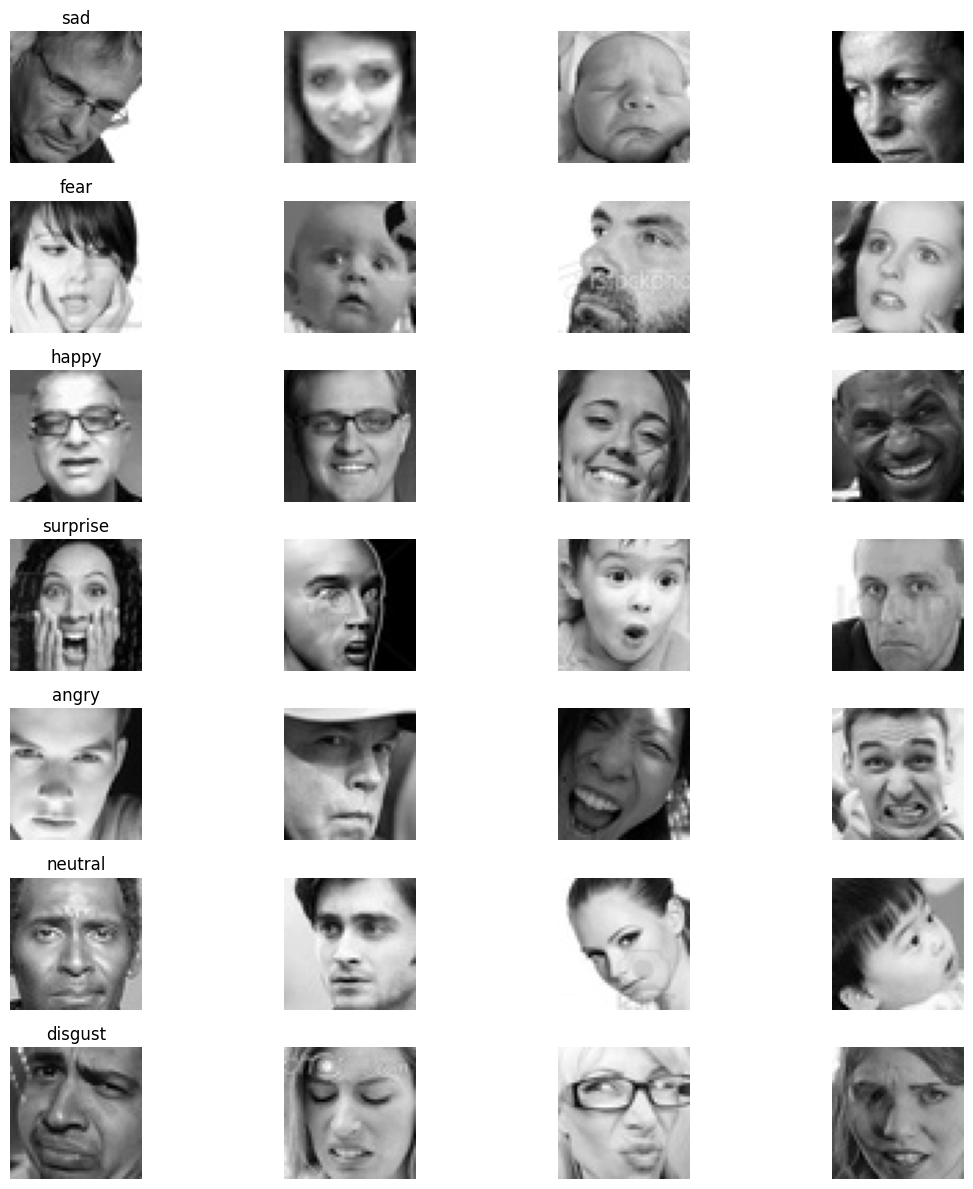

In [7]:
fig, axs = plt.subplots(len(emotions), 4, figsize=(12, 12))  # 7 emotions, 4 images per emotion

for n, emotion in enumerate(emotions):
    folder_path = os.path.join(train_dir, emotion)

    # Loop through the first 4 images for each emotion
    for i in range(4):
        img_path = os.path.join(folder_path, os.listdir(folder_path)[i])
        img = plt.imread(img_path)

        # Display the image in the correct subplot
        axs[n, i].imshow(img, cmap='gray')
        axs[n, i].set_title(emotion if i == 0 else "")  # Title only on the first image of each row
        axs[n, i].axis('off')  # Hide axis ticks and labels for a cleaner look

# Adjust layout to prevent overlapping of images and titles
plt.tight_layout()
plt.show()

# 1st Model

In [8]:
img_width, img_height = 48, 48
batch_size = 64
epochs = 10
num_classes = 7
data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

validation_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',)
    # subset='validation')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
model= models.Sequential([
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(img_width,img_height,1),kernel_initializer="he_normal",padding='same'),
    layers.Dropout(0.2),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.25),
    layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
    layers.Dropout(0.2),
    layers.Conv2D(256,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.25),
    layers.Conv2D(256,kernel_size=(3,3)),
    layers.LeakyReLU(alpha=0.1),
    #layers.Conv2D(256,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(1024,activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(num_classes,activation='softmax')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [10]:
"""from keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history2 = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator)"""

"from keras.optimizers import Adam\nmodel.compile(optimizer=Adam(learning_rate=0.0001),\n              loss='categorical_crossentropy',\n              metrics=['accuracy'])\nhistory2 = model.fit(\n    train_generator,\n    epochs=20,\n    validation_data=validation_generator)"

While the accuracy and loss metrics show improvement, the validation loss plateaus after the 14th epoch, suggesting that the model is overfitting.

In [11]:
model2= models.Sequential([
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(img_width,img_height,1),kernel_initializer='he_normal',padding='same'),
    layers.Dropout(0.2),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.2),
    layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Conv2D(256,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.2),
    layers.Conv2D(512,kernel_size=(3,3),activation='relu'),
    layers.Dropout(0.1),
    #layers.LeakyReLU(alpha=0.1),
    #layers.Conv2D(256,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(1024,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes,activation='softmax')
])


adding a new metric

In [12]:
def iou_metric(y_true, y_pred, smooth=1e-6):
    # Flatten the arrays
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    # Compute the intersection and union
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection

    # Compute IoU and add a small smooth value to avoid division by zero
    iou = (intersection + smooth) / (union + smooth)
    return iou


In [13]:
"""model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=[iou_metric,'accuracy'])
history = model2.fit(
    train_generator,
    epochs=60,
    validation_data=validation_generator)"""

"model2.compile(optimizer=Adam(learning_rate=0.001),\n              loss='categorical_crossentropy',\n              metrics=[iou_metric,'accuracy'])\nhistory = model2.fit(\n    train_generator,\n    epochs=60,\n    validation_data=validation_generator)"

To address overfitting, it is necessary to augment the data.

In [14]:
data_generator = ImageDataGenerator(
    rescale=1./255,
    #rotation_range=10,       # Randomly rotate images in the range : could lead to abnormal facial expressions so to avoid!
    width_shift_range=0.05,   # Randomly translate images horizontally
    height_shift_range=0.05,  # Randomly translate images vertically
    #shear_range=0.2,         # Shear angle in counter-clockwise direction in degrees: alters the face
    zoom_range=0.1,          # Randomly zoom in on images
    #horizontal_flip=True,     # Randomly flip images : Inaccurate data
    fill_mode='nearest',      # Points outside the boundaries are filled according to the given mode
    validation_split=0.2      # splitting training and validation data
)

# Create training data generator
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

# Create validation data generator
validation_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
)

# Create test data generator (no augmentation, just rescaling)
test_generator = ImageDataGenerator(
    rescale=1./255
).flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Second Model

In [15]:
model3= models.Sequential([
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(img_width,img_height,1),kernel_initializer='he_normal',padding='same'),
    layers.Dropout(0.2),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.2),
    layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Conv2D(256,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.2),
    layers.Conv2D(512,kernel_size=(3,3),activation='relu'),
    layers.Dropout(0.1),
    #layers.LeakyReLU(alpha=0.1),
    #layers.Conv2D(256,kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(1024,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes,activation='softmax')
])


In [16]:
"""from keras.optimizers import Adam
model3.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=[iou_metric,'accuracy'])"""

"from keras.optimizers import Adam\nmodel3.compile(optimizer=Adam(learning_rate=0.001),\n              loss='categorical_crossentropy',\n              metrics=[iou_metric,'accuracy'])"

In [17]:
"""history5 = model3.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator)"""

'history5 = model3.fit(\n    train_generator,\n    epochs=40,\n    validation_data=validation_generator)'

Due to the class imbalance, we're adding a new metric: weighted f1 score

In [18]:
def weighted_f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)
    support = K.sum(K.cast(y_true, 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1_per_class = 2 * (precision * recall) / (precision + recall + K.epsilon())
    weighted_f1 = K.sum(f1_per_class * support) / K.sum(support)

    return weighted_f1

This time we're adding checkpoints and adaptive learning rate

In [19]:
# Compile model with focal loss
model3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',weighted_f1_score,iou_metric]
)

# Define callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
checkpoint_callback = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train model with callbacks
history6 = model3.fit(
    train_generator,
    epochs=60,
    validation_data=validation_generator,
    callbacks=[lr_scheduler, checkpoint_callback]
)


Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2378 - iou_metric: 0.0967 - loss: 2.5008 - weighted_f1_score: 0.0085
Epoch 1: val_accuracy improved from -inf to 0.25466, saving model to best_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 53s 108ms/step - accuracy: 0.2379 - iou_metric: 0.0967 - loss: 2.4976 - weighted_f1_score: 0.0085 - val_accuracy: 0.2547 - val_iou_metric: 0.0961 - val_loss: 1.8032 - val_weighted_f1_score: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/60
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2799 - iou_metric: 0.1078 - loss: 1.7630 - weighted_f1_score: 0.0336
Epoch 2: val_accuracy did not improve from 0.25466
359/359 ━━━━━━━━━━━━━━━━━━━━ 58s 72ms/step - accuracy: 0.2800 - iou_metric: 0.1078 - loss: 1.7629 - weighted_f1_score: 0.0337 - val_accuracy: 0.2522 - val_iou_metric: 0.0981 - val_loss: 1.8564 - val_weighted_f1_score: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/60
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2960 - iou_metric: 0.1183 - 

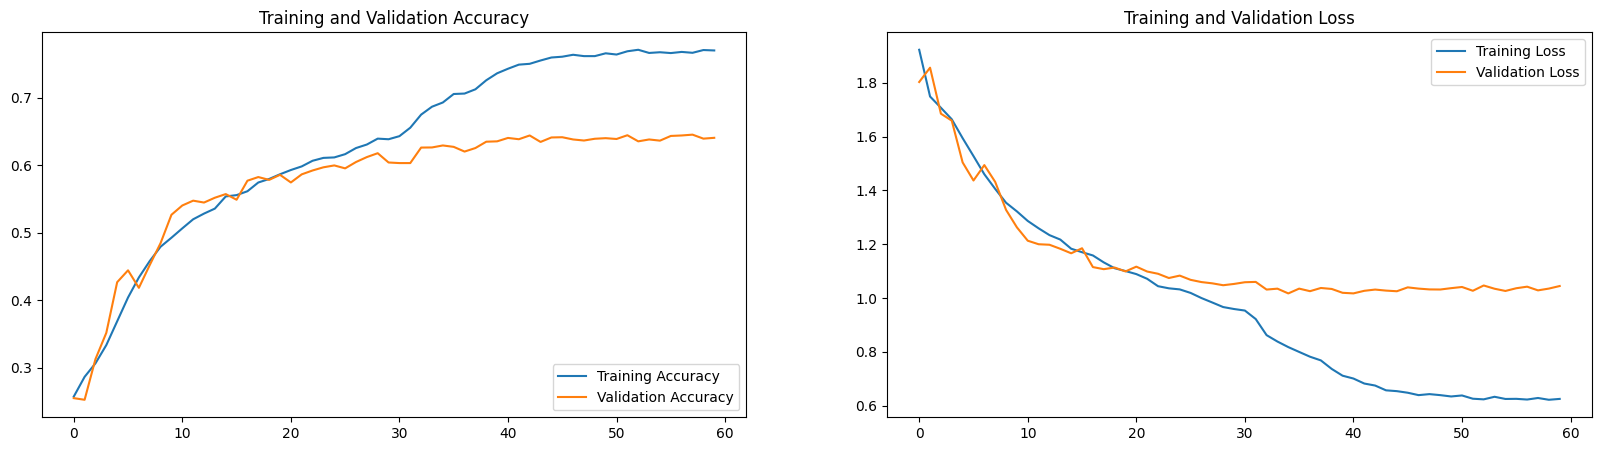

In [20]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()
plot_training_history(history6)

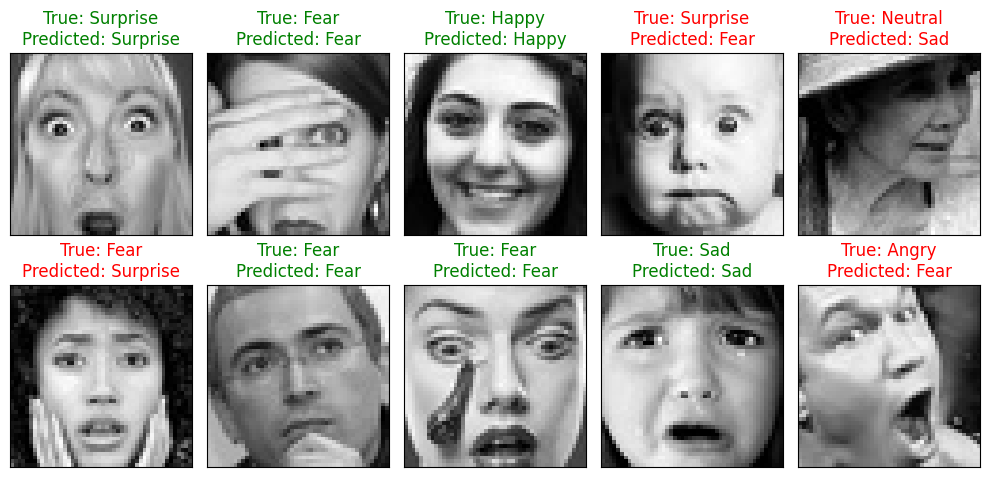

In [21]:
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model3.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()
